# Unbalanced penalization: A new approach to encode inequality constraints of combinatorial problems for quantum optimization algorithms

Solving combinatorial optimization problems of the kind that can be codified by quadratic unconstrained binary optimization (QUBO) is a promising application of quantum computation. Some problems of this class suitable for practical applications such as the traveling salesman problem (TSP), the bin packing problem (BPP), or the knapsack problem (KP) have inequality constraints that require a particular cost function encoding. The common approach is the use of slack variables to represent the inequality constraints in the cost function. However, the use of slack variables increases considerably the number of qubits and operations required to solve these problems us- ing quantum devices. In this work, we present an alternative method that does not require extra slack variables and consists of using an unbalanced penalization function to represent the inequality constraints in the QUBO. This function is characterized by having a larger penalization when the inequality constraint is not achieved than when it is. We tested our approach for the TSP, the BPP, and the KP. For all of them, we are able to encode the optimal solution in the vicinity of the cost Hamiltonian ground state. This new approach can be used to solve combinatorial problems with inequality constraints with a reduced number of resources compared to the slack variables approach using quantum annealing or variational quantum algorithms.

In [3]:
!pip install qiskit_optimization

  Using cached symengine-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.6 MB/s eta 0:00:00a 0:00:01
Using cached symengine-0.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.7 MB)
  Attempting uninstall: symengine
    Found existing installation: symengine 0.9.2
    Uninstalling symengine-0.9.2:
      Successfully uninstalled symengine-0.9.2
  Attempting uninstall: qiskit
    Found existing installation: qiskit 0.43.3
    Uninstalling qiskit-0.43.3:
      Successfully uninstalled qiskit-0.43.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openqaoa-qiskit 0.2.6 requires qiskit<1.0,>=0.36.1, but you have qiskit 1.3.2 which is incompatible.
qiskit-terra 0.24.2 requires symengine<0.10,>=0.9; platform_machine == "x86_64" or platform_machine == "aarch64

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from openqaoa import QAOA
from openqaoa.problems.converters import FromDocplex2IsingModel
from helper_functions import normalization
%matplotlib inline
graph_args = {"node_color":["salmon"],"edge_color":["mediumpurple"],"edgecolors":"black",
       "font_color":"white", "with_labels":True, "font_size":22, "node_size":700, "width":4}

## Traveling Salesman Problem (TSP)

In [5]:
from helper_functions import TSP

DOcplexException: Cannot solve model: no CPLEX runtime found.

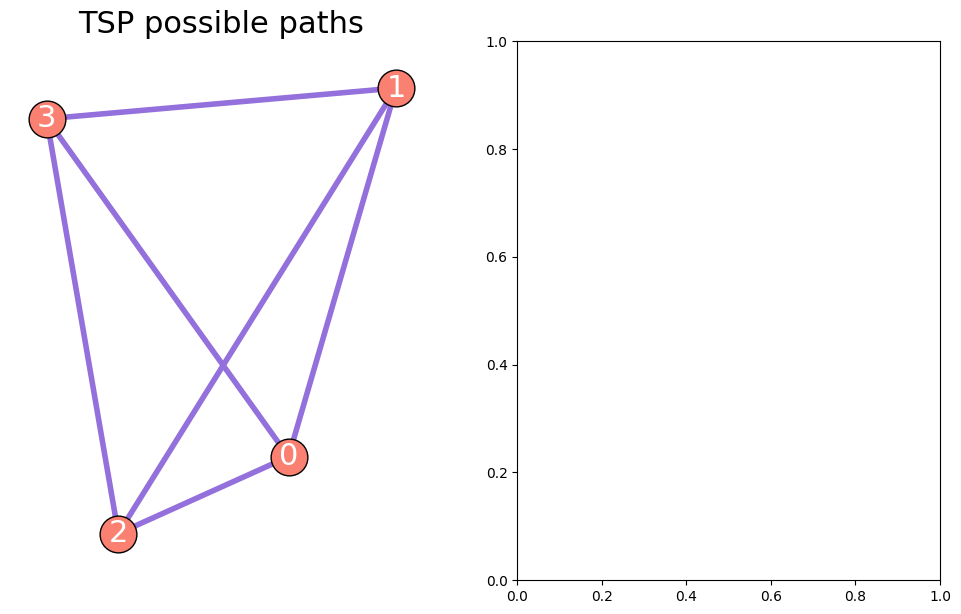

In [6]:
lx, ly = 50, 50 # The grid size where the points will be selected randomly
seed = 5
np.random.seed(seed)
cities  = 4
positions = {i: np.random.randint(0, [lx, ly], 2) for i in range(cities)}
G = nx.Graph()
G.add_nodes_from(range(cities))
for i in range(cities):
    for j in range(cities):
        if i != j:
            rij = np.sqrt(np.sum((positions[i] - positions[j])**2))
            G.add_weighted_edges_from([[i, j, rij]])
fig, ax = plt.subplots(1,2, figsize=(12, 7))
nx.draw(G, pos=positions, ax=ax[0], **graph_args)
ax[0].set_title("TSP possible paths", fontsize=22)
# Docplex model of the TSP problem 
tsp_model = TSP(G)
tsp_docplex_sol = tsp_model.solve() # Solving the problem using docplex
G_sol = nx.Graph()
sol = {}
for i in range(cities):
    for j in range(cities):
        if i != j:
            sol[f"x_{i}_{j}"] =tsp_docplex_sol.get_value(f"x_{i}_{j}")
        if i != j and tsp_docplex_sol.get_value(f"x_{i}_{j}"):
            G_sol.add_edges_from([[i,j]])
nx.draw(G_sol, pos=positions, ax=ax[1], style="--",**graph_args)
ax[1].set_title("TSP Solution Docplex", fontsize=22)

### Slack variables encoding

In [4]:
# Encode the inequality constraints of the problem using slack variables
tsp_slack = FromDocplex2IsingModel(tsp_model)
tsp_slack_sol = tsp_slack.qubo_docplex.solve()
tsp_slack_sol_str = ""
for ii in tsp_slack.qubo_docplex.iter_binary_vars():
    tsp_slack_sol_str += str(int(np.round(tsp_slack_sol.get_value(ii), 1)))
print(f"The number of variables (qubits) needed for the slack encoding is {tsp_slack.qubo_docplex.number_of_binary_variables}\n")
print(tsp_slack_sol)

The number of variables (qubits) needed for the slack encoding is 17

solution for: Copy of Copy of TSP
objective: 113.691
x_0_1=1
x_1_3=1
x_2_0=1
x_3_2=1
slack_C8_0=1



#### Solving using QAOA

In [5]:
p = 1
qaoa = QAOA()
norm_tsp_slack = normalization(tsp_slack.ising_model)
qaoa.set_circuit_properties(p=p)
qaoa.set_classical_optimizer(maxiter=1)
qaoa.compile(norm_tsp_slack)
qaoa.optimize()
sol_tsp_qaoa_slack = qaoa.results.lowest_cost_bitstrings(10000000)

Text(0, 0.5, 'probability')

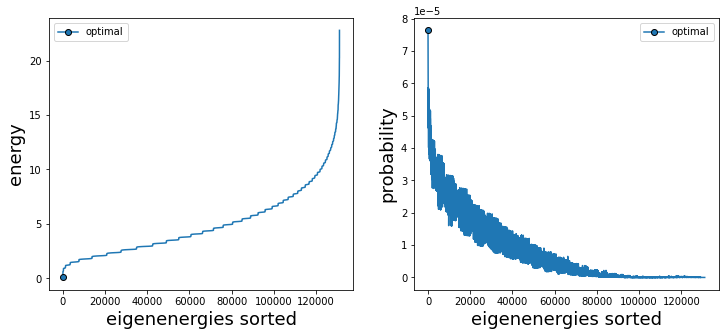

In [10]:
sol_tsp_qaoa_slack_dict = {sol_tsp_qaoa_slack["solutions_bitstrings"][i]:i
                           for i in range(len(sol_tsp_qaoa_slack["solutions_bitstrings"]))} 

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(sol_tsp_qaoa_slack["bitstrings_energies"])
ax[1].plot(sol_tsp_qaoa_slack["probabilities"])
pos = sol_tsp_qaoa_slack_dict[tsp_slack_sol_str]
ax[0].plot(pos, sol_tsp_qaoa_slack["bitstrings_energies"][pos],
           marker="o", linestyle=None, color="tab:blue", markeredgecolor="black", label="optimal")
ax[1].plot(pos, sol_tsp_qaoa_slack["probabilities"][pos],
           marker="o", linestyle=None, color="tab:blue", markeredgecolor="black", label="optimal")
for i in range(2):
    ax[i].set_xlabel("eigenenergies sorted", fontsize=18)
    ax[i].legend()
ax[0].set_ylabel("energy", fontsize=18)
ax[1].set_ylabel("probability", fontsize=18)

### Unbalanced penalization encoding

In [11]:
# Encode the inequality constraints of the problem using the unbalanced penalization approach
lambda0 = 38.2584 #Preoptimized values (see ref.1)
lambda1 = 18.2838
lambda2 = 57.0375
tsp_unbalanced = FromDocplex2IsingModel(tsp_model, multipliers=lambda0, unbalanced_const=True,
                                             strength_ineq=[lambda2/lambda0, lambda1/lambda0])
tsp_unbalanced_sol = tsp_unbalanced.qubo_docplex.solve()
tsp_unbalanced_sol_str = ""
for ii in tsp_unbalanced.qubo_docplex.iter_binary_vars():
    tsp_unbalanced_sol_str += str(int(np.round(tsp_unbalanced_sol.get_value(ii), 1)))
# Note that the strength_ineq will be multiplied by lambda0 inside the FromDocplex2IsingModel function
print(f"The number of variables (qubits) needed for the unbalanced encoding is {tsp_unbalanced.qubo_docplex.number_of_binary_variables}\n")
print(tsp_unbalanced_sol)

The number of variables (qubits) needed for the unbalanced encoding is 12

solution for: Copy of Copy of TSP
objective: 152.445
x_0_2=1
x_1_0=1
x_2_3=1
x_3_1=1



In [12]:
p = 1
qaoa_unbalanced = QAOA()
norm_tsp_slack = normalization(tsp_unbalanced.ising_model)
qaoa_unbalanced.set_circuit_properties(p=p)
qaoa_unbalanced.set_classical_optimizer(maxiter=1)
qaoa_unbalanced.compile(norm_tsp_slack)
qaoa_unbalanced.optimize()
sol_tsp_qaoa_unbalanced = qaoa_unbalanced.results.lowest_cost_bitstrings(10000000)

Text(0, 0.5, 'probability')

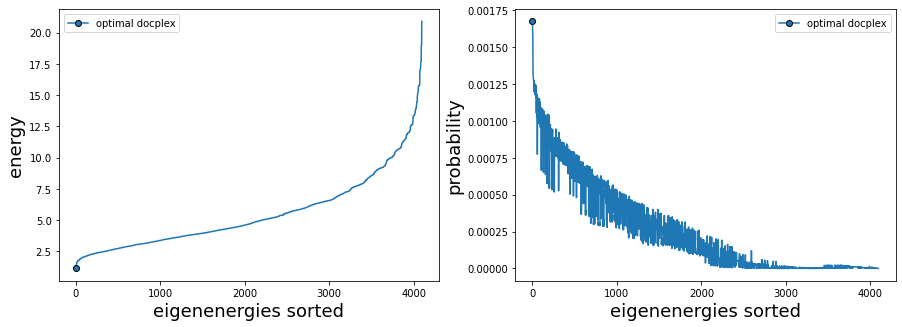

In [15]:
tsp_qaoa_unbalanced_dict = {sol_tsp_qaoa_unbalanced["solutions_bitstrings"][i]:i
                            for i in range(len(sol_tsp_qaoa_unbalanced["solutions_bitstrings"]))} 
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(sol_tsp_qaoa_unbalanced["bitstrings_energies"])
ax[1].plot(sol_tsp_qaoa_unbalanced["probabilities"])
pos = tsp_qaoa_unbalanced_dict[tsp_unbalanced_sol_str]
ax[0].plot(pos, sol_tsp_qaoa_unbalanced["bitstrings_energies"][pos],
           marker="o", linestyle=None, color="tab:blue", markeredgecolor="black", label="optimal docplex")
ax[1].plot(pos, sol_tsp_qaoa_unbalanced["probabilities"][pos],
           marker="o", linestyle=None, color="tab:blue", markeredgecolor="black", label="optimal docplex")
for i in range(2):
    ax[i].set_xlabel("eigenenergies sorted", fontsize=18)
    ax[i].legend()
ax[0].set_ylabel("energy", fontsize=18)
ax[1].set_ylabel("probability", fontsize=18)

In [16]:
grid = 25
betas = np.linspace(-np.pi/2,0, grid)
gammas = np.linspace(-np.pi, 0, grid)
varational_params = qaoa_unbalanced.variate_params
energy = []
for beta in betas:
    for gamma in gammas:
        varational_params.update_from_raw([beta, gamma])
        energy.append(qaoa_unbalanced.backend.expectation(varational_params))
energy = np.array(energy).reshape(grid, grid)

Text(0.5, 1.0, 'energy landscape QAOA p = 1\n unbalanced penalization method')

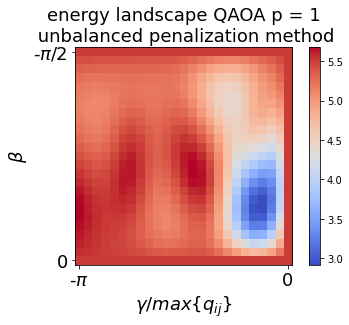

In [20]:
fig, ax = plt.subplots()
ax1 = ax.imshow(energy, cmap="coolwarm")
fig.colorbar(ax1)
ax.set_xticks([0,grid-1])
ax.set_yticks([0,grid-1])
ax.set_yticklabels([r"-$\pi/2$", "0"], fontsize=18)
ax.set_xticklabels([r"-$\pi$", "0"], fontsize=18)
ax.set_xlabel(r"$\gamma/max\{q_{ij}\}$", fontsize=18)
ax.set_ylabel(r"$\beta$", fontsize=18)
ax.set_title("energy landscape QAOA p = 1\n unbalanced penalization method", fontsize=18)